In [13]:
# here we take a statistic
# let's load in the word/English.json.gz file
# then we 
import json
import gzip
import sys
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('/Users/hope/Documents/10 Projects/14 PhD/14.01 Github/literary-translation')
from scripts.utils import Location

def load_json_gz(file):
    # with gzip.open(args.input, "rt") as ifd, gzip.open(args.output, "wt") as ofd:
    #     batch = []
    #     for i, line in enumerate(ifd):
    #         item = json.loads(line)
    #         loc = Location(item["location"])
    #         batch.append((loc, item["text"]))
    df = []
    with gzip.open(file, 'rt') as f:
        for i, line in enumerate(f):
            item = json.loads(line)
            loc = Location(item["location"])
            df.append({'book': loc['book'], 'chapter': loc['chapter'], 'verse': loc['verse'], 'text':item["text"]})

    return pd.DataFrame.from_records(df)
        


In [28]:
# import pandas as pd

# bible = pd.read_csv("../bibles/eng_ENGESV.api.txt", sep='\t', 
#                     header=None, 
#                     names=['ref', 'text'],
#                     dtype = {'ref': str, 'text': str})
# bible['book'] = bible['ref'].apply(lambda x: int(x[:2]))
# bible['chapter'] = bible['ref'].apply(lambda x: int(x[2:5]))
# bible['verse'] = bible['ref'].apply(lambda x: int(x[-2:]))
# bible.head()

FileNotFoundError: [Errno 2] No such file or directory: '../bibles/eng_ENGESV.api.txt'

In [25]:
df = load_json_gz('../work/English.json.gz')
df.head()

,book,chapter,verse,text
0,GEN,1,1,In the beginning God created the heaven and th...
1,GEN,1,2,"And the earth was without form, and void; and ..."
2,GEN,1,3,"And God said, Let there be light: and there wa..."
3,GEN,1,4,"And God saw the light, that it was good: and G..."
4,GEN,1,5,"And God called the light Day, and the darkness..."


In [15]:
bible_embeds = np.load('bible_embeds.npy')
bible_embeds.shape

(31086, 768)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(bible_embeds,bible_embeds)

In [20]:
def get_chiasm_score(cos_sim, i=0, n=4, sim_threshold=0.95):
    # the basic chiasm score is the sum of ther reversed diagonal elements of the cosine similarity matrix
    # then we add a penalty for high similarity scores between different levels. Setting the threshold very high means we're just trying to capture
    # cases where text reuse is very high
    # scores = []
    # for i in range(0, cos_sim.shape[0]-n+1):
    score = cos_sim[i:i+n, i:i+n][::-1].trace()
    # adding a penalty for high similarity scores between different levels
    for j in range(1,n):
        if cos_sim[i+j, i+n-1-j] > sim_threshold:
            score -= cos_sim[i+j, i+n-1-j]
    return score

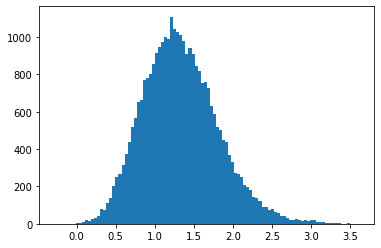

In [19]:
# we get the chiasm_score for n=4, then plot the probability distribution of scores
scores = get_chiasm_score(cos_sim, n=4, sim_threshold=0.95)
plt.hist(scores, bins=100)
plt.show()

In [56]:
from tqdm import tqdm
# want to modify the chiasm function to take in a starting position and and n value, return the score.
# we then want to select 1000 random starting positions and calculate their chiasm score, 
# then we calculate the p-value as the proportion of random chiasm_scores that are equal to or greater than your actual chiasm_score.
p_values = {}
for n in [3, 4, 5,]:
    p_values[n] = []
    for i in tqdm(range(0, cos_sim.shape[0]-n+1)):
        candidate= get_chiasm_score(cos_sim, i, n, 0.95)
        # print(f'chiasm score for n={n} and i={i}: {candidate}')
        # print(candidate)
        scores = []
        for _  in range(100):
            random_start = np.random.randint(0, cos_sim.shape[0]-n+1)
            scores.append(get_chiasm_score(cos_sim, random_start, n, 0.95))
        # calculate p-value
        p = sum([1 for s in scores if s >= candidate])/len(scores)
        p_values[n].append(p)
        # print(f'p-value for n={n}: {p}')

# # make an array of the p-values
# p_values_array = np.array([p_values[n] for n in p_values.keys()]).T


  0%|          | 56/31084 [00:00<00:55, 557.85it/s]

100%|██████████| 31082/31082 [01:11<00:00, 435.31it/s]


In [43]:
[len(v) for k,v in p_values.items()] # different sizes bc the n-value changes the window size
# I think we just cut off the last few values to make them the same size
min_len = min([len(v) for k,v in p_values.items()])
p_values_array = np.array([v[:min_len] for k,v in p_values.items()]).T
p_values_array.shape

(31082, 3)

In [55]:
pd.DataFrame.from_records(p_values_array, columns=['n=3', 'n=4', 'n=5']).head()#.to_csv('p_values.csv', index=False)

,n=3,n=4,n=5
0,0.3,0.5,0.0
1,0.4,0.0,0.1
2,0.1,0.0,0.2
3,0.0,0.1,0.0
4,0.3,0.0,0.0


In [54]:
# these are the p values for the chiasm scores for n=3, 4, 5 for the initial starting position
# I want to take the minimum of this
p_values_array[:10]
# find minimum in each row
min_p_values = np.min(p_values_array, axis=1)
min_p_values[:10]
# if these values are under the p-value threshold, then we can say that the chiasm is significant
# we can then plot the p-values
# want to get the indices of the minimum p-values
min_p_values_indices = np.argmin(p_values_array, axis=1)
min_p_values_indices[:10]

array([2, 1, 1, 0, 1, 1, 0, 0, 0, 1])

ValueError: x and y must have same first dimension, but have shapes (31082,) and (3,)

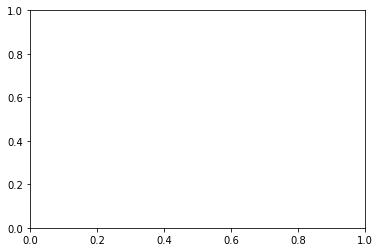

In [49]:
# now we can plot the p-values
plt.plot(p_values_array[0])

# plt.legend([f'n={n}' for n in p_values.keys()])
plt.show()